In [1]:
!pip install cdsapi --quiet
import cdsapi
import urllib.request
from itertools import product
import s3fs, boto3, botocore, pooch
from pythia_datasets import DATASETS
import os, sys, glob, platform, tempfile
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader

# **<font size=10 color='F00000'>NCEP-NCAR version 1</font>**

**site: https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis**

In [2]:
def download_from_ncep(var_list=[], year=None, dataset='NCEP-NCAR-v1', temporal_res='monthly', level_type='pressure'):
    for var in var_list:
        if   temporal_res == 'monthly':
            add_flag = 'Monthlies/'
            filename = f"{var}.mon.mean.nc"
        elif temporal_res == 'daily':
            add_flag = ''
            filename = f"{var}.{year}.nc"
        
        url = f"https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/{add_flag}{level_type}/{filename}"
        save_path = os.path.join(dataset, temporal_res, level_type)
        url = url.replace('near_', '') if level_type == 'near_surface' else url
        
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        if not os.path.exists(os.path.join(save_path, filename)):
            try:
                print(f'Downloading {url}...')
                urllib.request.urlretrieve(url, os.path.join(save_path, filename))
            except:
                print(f'{url} does not exist. ')
                continue

In [3]:
level_type = 'pressure'
temporal_res = 'monthly'
start_year, end_year = 1995, 2000

sfc_var_list  = ['lftx.sfc', 'lftx4.sfc', 'pres.sfc', 'pr_wtr.eatm', 'slp']
nsfc_var_list = [i + '.sig995' for i in ['air', 'omega', 'pottmp', 'rhum', 'uwnd', 'vwnd']]
pres_var_list = ['air', 'hgt', 'omega', 'rhum', 'shum', 'uwnd', 'vwnd']
if temporal_res == 'monthly':
    sfc_var_list  += ['air', 'pres', 'pr_wtr', 'rhum', 'uwnd', 'vwnd', 'wspd', 
                      'thickness', 'thickness_500200', 'thickness_850500', 'thickness_1000500']
    nsfc_var_list += ['wspd.sig995']
    pres_var_list += ['wspd', 'pottmp']

for year in range(start_year, end_year + 1):
    download_from_ncep(var_list=pres_var_list, level_type=level_type, 
                       year=year, temporal_res=temporal_res, 
                       dataset='NCEP-NCAR-v1')

In [4]:
temporal_res = 'daily'
start_year, end_year = 1995, 2000
sfc_var_list  = ['lftx.sfc', 'lftx4.sfc', 'pres.sfc', 'pr_wtr.eatm', 'slp']

for idx, var in enumerate(sfc_var_list):
    ds_list = []
    for year in range(start_year, end_year + 1):
        file_path = os.path.join('NCEP-NCAR-v1', 'daily', 'surface', f"{var}.{year}.nc")
        ds_temp = xr.open_dataset(file_path)
        ds_list.append(ds_temp.sel(time=ds_temp.time.dt.hour == 0))
        del ds_temp
    ds_temp = xr.concat(ds_list, dim='time')
    ds_sfc_daily = ds_temp if idx == 0 else xr.merge([ds_sfc_daily, ds_temp])
    del ds_temp

In [6]:
temporal_res = 'daily'
start_year, end_year = 1995, 2000
nsfc_var_list = [i + '.sig995' for i in ['air', 'omega', 'pottmp', 'rhum', 'uwnd', 'vwnd']]

for idx, var in enumerate(nsfc_var_list):
    ds_list = []
    for year in range(start_year, end_year + 1):
        file_path = os.path.join('NCEP-NCAR-v1', 'daily', 'near_surface', f"{var}.{year}.nc")
        ds_temp = xr.open_dataset(file_path)
        ds_list.append(ds_temp.sel(time=ds_temp.time.dt.hour == 0))
        del ds_temp
    ds_temp = xr.concat(ds_list, dim='time')
    ds_nsfc_daily = ds_temp if idx == 0 else xr.merge([ds_nsfc_daily, ds_temp])
    del ds_temp

In [11]:
temporal_res = 'daily'
start_year, end_year = 1995, 2000
pres_var_list = ['air', 'hgt', 'omega', 'rhum', 'shum', 'uwnd', 'vwnd']

for idx, var in enumerate(pres_var_list):
    ds_list = []
    for year in range(start_year, end_year + 1):
        file_path = os.path.join('NCEP-NCAR-v1', 'daily', 'pressure', f"{var}.{year}.nc")
        ds_temp = xr.open_dataset(file_path)
        ds_list.append(ds_temp.sel(time=ds_temp.time.dt.hour == 0))
        del ds_temp
    ds_temp = xr.concat(ds_list, dim='time')
    ds_pres_daily = ds_temp if idx == 0 else xr.merge([ds_pres_daily, ds_temp])
    del ds_temp

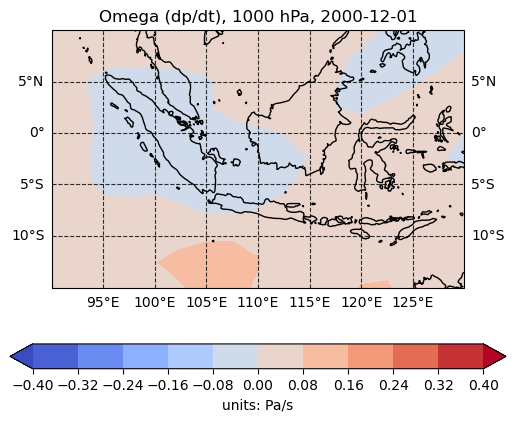

In [34]:
time = '2000-12-01'
level = 1000.0
var = ds3.omega.sel(time=time, level=level, lat=slice(10, -15), lon=slice(90, 130)).squeeze()

proj = ccrs.Mercator(central_longitude=110.0)
fig, ax = plt.subplots(subplot_kw={'projection': proj})
im = ax.contourf(var.lon, var.lat, var, transform=ccrs.PlateCarree(), 
                 levels=np.linspace(-0.4, 0.4, 11), extend='both', cmap='coolwarm')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', alpha=0.8, linewidth=0.8, linestyle='dashed')
gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()
gl.top_labels = False

ax.coastlines()
ax.set_title(f"{var.attrs['var_desc']}, {level:.0f} hPa, {time}")

fig.colorbar(im, label='units: Pa/s', orientation='horizontal', 
             ticks=np.linspace(-0.4, 0.4, 11), extend='both')

In [7]:
temporal_res = 'monthly'
sfc_var_list  = ['lftx.sfc', 'lftx4.sfc', 'pres.sfc', 'pr_wtr.eatm', 'slp', 'air', 'pres', 'pr_wtr', 'rhum', 'uwnd', 'vwnd', 'wspd', 
                 'thickness', 'thickness_500200', 'thickness_850500', 'thickness_1000500']

for idx, var in enumerate(sfc_var_list):
    file_path = os.path.join('NCEP-NCAR-v1', 'monthly', 'surface', f"{var}.mon.mean.nc")
    ds_temp = xr.open_dataset(file_path)
    ds_sfc_monthly = ds_temp if idx == 0 else xr.merge([ds_sfc_monthly, ds_temp])
    del ds_temp

type: conflicting values for variable 'thickness' on objects to be combined. You can skip this check by specifying compat='override'.

In [ ]:
temporal_res = 'monthly'
nsfc_var_list  = [i + '.sig995' for i in ['air', 'omega', 'pottmp', 'rhum', 'uwnd', 'vwnd', 'wspd']]

for idx, var in enumerate(nsfc_var_list):
    file_path = os.path.join('NCEP-NCAR-v1', 'monthly', 'near_surface', f"{var}.mon.mean.nc")
    ds_temp = xr.open_dataset(file_path)
    ds_nsfc_monthly = ds_temp if idx == 0 else xr.merge([ds_nsfc_monthly, ds_temp])
    del ds_temp

In [ ]:
temporal_res = 'monthly'
pres_var_list  = ['air', 'hgt', 'omega', 'rhum', 'shum', 'uwnd', 'vwnd', 'wspd', 'pottmp']

for idx, var in enumerate(pres_var_list):
    file_path = os.path.join('NCEP-NCAR-v1', 'monthly', 'surface', f"{var}.mon.mean.nc")
    ds_temp = xr.open_dataset(file_path)
    ds_pres_monthly = ds_temp if idx == 0 else xr.merge([ds_pres_monthly, ds_temp])
    del ds_temp

# <font size=10 color='Magenta'>ERA5</font>

In [2]:
!echo "url: https://cds.climate.copernicus.eu/api/v2" > $HOME/.cdsapirc
!echo "key: 144377:8a50e374-1d14-4e1b-a712-fbee23a2e853" >> $HOME/.cdsapirc
!cat $HOME/.cdsapirc

url: https://cds.climate.copernicus.eu/api/v2
key: 144377:8a50e374-1d14-4e1b-a712-fbee23a2e853


In [9]:
def download_from_ecmwf(mode='LM', extra_flag="no", fname=None, 
                        years=None, months=None, days=None, times=None, 
                        area=[90, -180, -90, 180], pressures=None):
    temporal_res = {'H': 'hourly', 'M': 'monthly'}
    level_type   = {'L': 'land'  , 'S': 'single_level', 'P': 'pressure_levels'}
    file_name = os.path.join("ERA5", temporal_res[mode[-1]], level_type[mode[0]], fname)
    line1 = {'LH':            'land', 'LM':            'land-monthly-means',
             'SH':   'single-levels', 'SM':   'single-levels-monthly-means',
             'PH': 'pressure-levels', 'PM': 'pressure-levels-monthly-means'}
    product_type = {'H': 'reanalysis', 'M': 'monthly_averaged_reanalysis'}
    variables = {'L': ['10m_u_component_of_wind', '10m_v_component_of_wind', 
                       'skin_temperature', '2m_temperature', 
                       'surface_pressure', 
                       'total_precipitation'], 
                 'S': ['10m_u_component_of_wind', '10m_v_component_of_wind', '100m_u_component_of_wind', '100m_v_component_of_wind', 
                       'skin_temperature', '2m_temperature', 'sea_surface_temperature', 
                       'surface_pressure', 'mean_sea_level_pressure', 
                       'convective_precipitation', 'convective_rain_rate', 'large_scale_precipitation', 'large_scale_rain_rate', 'total_precipitation'],
                 'P': ['u_component_of_wind', 'v_component_of_wind', 'vertical_velocity', 
                        'temperature', 
                        'geopotential', 
                        'relative_humidity', 'specific_humidity']}
    extra_variables = {"yes": {'L': ['2m_dewpoint_temperature'],
                               'S': ['2m_dewpoint_temperature', 'convective_available_potential_energy', 'mean_vertically_integrated_moisture_divergence'],
                               'P': ['divergence', 'fraction_of_cloud_cover', 'ozone_mass_mixing_ratio', 'potential_vorticity', 'specific_cloud_ice_water_content', 'specific_cloud_liquid_water_content', 'specific_rain_water_content', 'specific_snow_water_content', 'vorticity', ], },
                       "no": {'L': [], 'S': [], 'P': [], }}
    pressure_level = {'pressure_level': pressures}
    dict_day = {'day': days}
    
    c = cdsapi.Client()
    retrieve_dict = {
        'product_type': product_type[mode[-1]],
        'variable': variables[mode[0]] + extra_variables[extra_flag][mode[0]],
        'year': years,
        'month': months,
        'time': times,
        'format': 'netcdf',
        'area': area}
    if mode == 'LH':
        retrieve_dict = {key: value for key, value in retrieve_dict.items() if key not in {'product_type': []}}
    if mode[0] == 'P':
        retrieve_dict.update(pressure_level)
    if mode[1] == 'H':
        retrieve_dict.update(dict_day)
    if not os.path.exists(os.path.dirname(file_name)):
        os.makedirs(os.path.dirname(file_name))
    if not os.path.exists(file_name):
        c.retrieve(f"reanalysis-era5-{line1[mode]}", retrieve_dict , file_name)

In [ ]:
start_year, end_year = 1996, 2005
mode     = 'SH'
fname = f"{start_year}-{end_year}_{mode}.nc"
extra_flag = "no"
pressures = ['1000']
years = [str(year) for year in range(start_year, end_year + 1)]
months = [f"{month:02}" for month in range(1, 12 + 1)]
days = [f"{day:02}" for day in range(1, 31 + 1)]
times = ['00:00']

area = [90, -180, -90, 180]

download_from_ecmwf(mode='SH', extra_flag="no", fname=fname, 
                        years=years, months=months, days=days, times=times, 
                        area=[90, -180, -90, 180], pressures=None)

2023-07-26 12:55:08,284 INFO Welcome to the CDS
2023-07-26 12:55:08,285 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-07-26 12:55:08,439 INFO Request is queued


In [20]:
file_path = os.path.join('ERA5', 'hourly', 'single_level', '1996-2005.SH.nc')
ds4 = xr.open_dataset().squeeze()
ds4

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2016-01-01
Data variables: (12/14)
    u10        (latitude, longitude) float32 ...
    v10        (latitude, longitude) float32 ...
    u100       (latitude, longitude) float32 ...
    v100       (latitude, longitude) float32 ...
    skt        (latitude, longitude) float32 ...
    t2m        (latitude, longitude) float32 ...
    ...         ...
    msl        (latitude, longitude) float32 ...
    cp         (latitude, longitude) float32 ...
    crr        (latitude, longitude) float32 ...
    lsp        (latitude, longitude) float32 ...
    lsrr       (latitude, longitude) float32 ...
    tp         (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-26 12:25:06 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

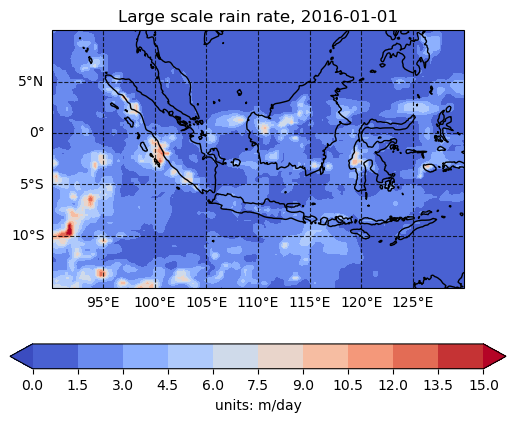

In [25]:
# time = '2000-12-01'
# level = 1000.0
var = ds4.lsrr.sel(latitude=slice(10, -15), longitude=slice(90, 130)).squeeze()

proj = ccrs.Mercator(central_longitude=110.0)
fig, ax = plt.subplots(subplot_kw={'projection': proj})
im = ax.contourf(var.longitude, var.latitude, 86400.0 * var, transform=ccrs.PlateCarree(), 
                 levels=np.linspace(0, 15, 11), extend='both', cmap='coolwarm')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', alpha=0.8, linewidth=0.8, linestyle='dashed')
gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()
gl.top_labels = False
gl.right_labels = False

ax.coastlines()
ax.set_title(f"{var.attrs['long_name']}, 2016-01-01")

fig.colorbar(im, label='units: m/day', orientation='horizontal', 
             ticks=np.linspace(0, 15, 11), extend='both')